# Multiresolution Hash Encoding

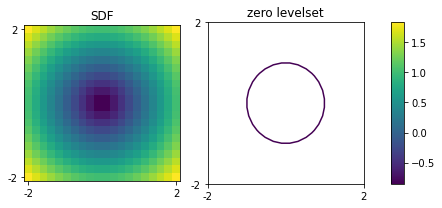

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap
from jax.config import config
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
import functools as ft
import optax
import treex as tx
from sdf_jax import plot2d, discretize2d
from sdf_jax import SimpleNeuralSDF, train_step


def sdf_sphere(x):
    return jnp.linalg.norm(x) - 1

plot2d(sdf_sphere, ngrid=20)

## Benchmark Multiresolution Hash Enconding

In [2]:
import hash_encoding
# x = jnp.array([1.1, 2.2, 1.3])
x = jnp.array([1.1, 2.2])
key = jrandom.PRNGKey(1234)
key, theta_key = jrandom.split(key, 2)
theta = hash_encoding.init_encoding(theta_key)
theta.shape

(16, 16384, 2)

In [3]:
hash_encoding.encode(x, theta).block_until_ready()

DeviceArray([[ 3.3179367e-05,  5.5721015e-05],
             [ 7.7157019e-06, -7.0495698e-05],
             [ 2.0955800e-05, -1.3705347e-05],
             [-8.9430532e-06,  1.3349578e-05],
             [-8.1839156e-05,  9.1779133e-05],
             [ 1.1673975e-05, -3.9121507e-05],
             [ 2.0934371e-05, -2.1427069e-05],
             [ 7.5820542e-05, -9.2341514e-05],
             [ 6.0841903e-05,  3.5381359e-05],
             [ 1.0138128e-05,  5.8133423e-06],
             [ 3.7074387e-05, -1.6676368e-05],
             [ 3.1593896e-05,  1.7053600e-05],
             [-1.2684795e-05,  4.6095029e-06],
             [-1.5719470e-05, -7.0969334e-05],
             [ 5.6912213e-06, -1.7089391e-05],
             [-1.5906831e-05, -2.2623879e-05]], dtype=float32)

In [4]:
%timeit hash_encoding.encode(x, theta).block_until_ready()

7.34 µs ± 601 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [6]:
@jax.jit
def encode_batch(x, theta):
    return vmap(lambda x: hash_encoding.encode(x, theta))(x)

key, xs_key = jrandom.split(key, 2)
xs = jrandom.uniform(xs_key, (1_000_000, 3))
encode_batch(xs, theta).shape

(1000000, 16, 2)

In [7]:
%timeit encode_batch(xs, theta).block_until_ready()

774 ms ± 48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
xs = jrandom.uniform(xs_key, (1_000_000, 2))
%timeit encode_batch(xs, theta).block_until_ready()

280 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Use in SDF

In [9]:
class HashEmbedding(tx.Module):
    theta: jnp.ndarray = tx.Parameter.node()

    def __init__(
        self, 
        levels: int=16, 
        hashmap_size_log2: int=14, 
        features_per_entry: int=2,
        nmin: int=16,
        nmax: int=512,
    ):
        self.levels = levels
        self.hashmap_size_log2 = hashmap_size_log2
        self.features_per_entry = features_per_entry
        self.nmin = nmin
        self.nmax = nmax

    def __call__(self, x):
        assert x.ndim == 1
        if self.initializing():
            hashmap_size = 1 << self.hashmap_size_log2
            key = tx.next_key()
            self.theta = jrandom.uniform(
                key, 
                (self.levels, hashmap_size, self.features_per_entry), 
                minval=-0.0001, 
                maxval=0.0001
            )
        
        y = hash_encoding.encode(x, self.theta, self.nmin, self.nmax)
        return y.reshape(-1)

emb = HashEmbedding().init(key=42, inputs=x)
emb(x).shape

(32,)

In [10]:
model = tx.Sequential(
    HashEmbedding(),
    tx.Linear(64),
    jax.nn.softplus,
    tx.Linear(1),
    lambda x: x[0]
).init(key=42, inputs=x)
model(x)

DeviceArray(0.19094317, dtype=float32)

/home/niku/Documents/cloud/tu/cgproject/cg-project/sdf_jax.py:36: UserWarning: No contour levels were found within the data range.
  ax1.contour(ys, levels=[0.])


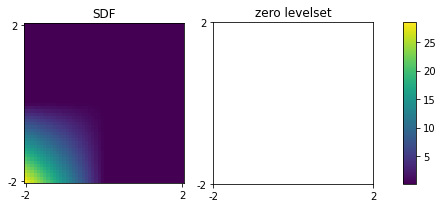

In [11]:
plot2d(model, ngrid=50)

  0%|          | 0/2000 [00:00<?, ?it/s]

[0] loss: 3.1318
[200] loss: 1.7296
[400] loss: 1.4366
[600] loss: 1.4419
[800] loss: 1.3463
[1000] loss: 0.7755
[1200] loss: 0.3839
[1400] loss: 3.1289
[1600] loss: 1.4216
[1800] loss: 0.8689


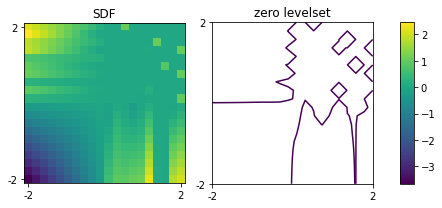

In [12]:
from sdf_jax import train_step, print_callback
from tqdm.notebook import tqdm

def fit(
    sdf=sdf_sphere,
    xy_lims=(-2, 2),
    ngrid=20,
    n_samples=50,
    # module
    act=jax.nn.relu,
    emb_kwargs={},
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=5e-3,
    steps=100,
    # utils
    cb=print_callback,
    cb_every=10,
):
    key, model_key, data_key = jrandom.split(key, 3)
    xs, ys = discretize2d(sdf, xy_lims=xy_lims, ngrid=ngrid)
    xs = xs.reshape(-1, 2)
    ys = ys.reshape(-1)
    train_idx = jrandom.choice(data_key, len(xs), (n_samples,), replace=False)
    xs = xs[train_idx]
    ys = ys[train_idx]
    model = tx.Sequential(
        HashEmbedding(**emb_kwargs),
        tx.Linear(64),
        act,
        tx.Linear(64),
        act,
        tx.Linear(1),
        lambda x: x[0]
    ).init(key=model_key, inputs=xs[0])
    optimizer = tx.Optimizer(optax.adam(lr, b1=0.9, b2=0.99, eps=1e-15))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    for step in tqdm(range(steps)):
        loss, model, optimizer = train_step(model, xs, ys, optimizer)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    return loss, model

loss, model = fit(lr=1e-4, steps=2000, cb_every=200)
plot2d(model, ngrid=20)

  0%|          | 0/500 [00:00<?, ?it/s]

[0] loss: 0.8692
[100] loss: 0.3349
[200] loss: 0.0455
[300] loss: 0.0067
[400] loss: 0.0027


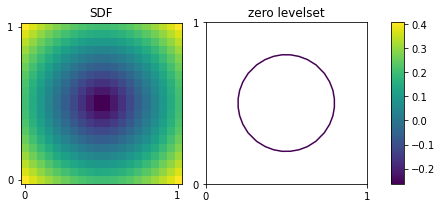

In [13]:
# it seems coordinates matter a lot.
# is the unit square a default assumption ?
# TODO investigate / think

def sdf_sphere2(x):
    center = np.array([0.5, 0.5])
    radius = 0.3
    return jnp.linalg.norm(x - center) - radius

loss, model = fit(
    sdf_sphere2, 
    xy_lims=(0,1),
    n_samples=400,
    emb_kwargs={"nmax": 32}, # set nmax higher to overfit to grid
    lr=1e-4, 
    steps=500, 
    cb_every=100,
)
# plot2d(model, ngrid=20, xy_lims=(0,1))
plot2d(model, ngrid=20, xy_lims=(0,1))

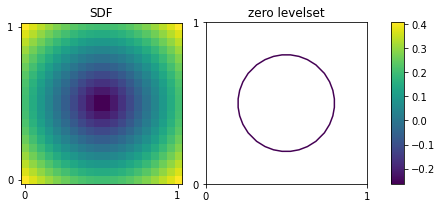

In [14]:
plot2d(sdf_sphere2, ngrid=20, xy_lims=(0,1))

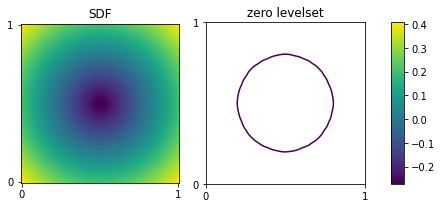

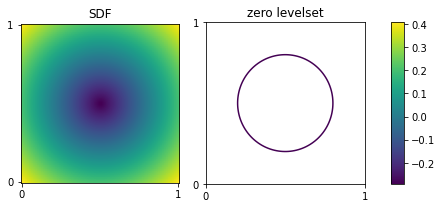

In [15]:
plot2d(model, ngrid=80, xy_lims=(0,1))
plot2d(sdf_sphere2, ngrid=80, xy_lims=(0,1))

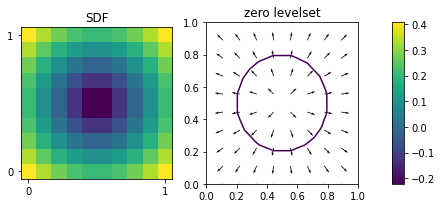

In [16]:
@ft.partial(jax.jit, static_argnums=(0,2))
def discretize2d_normals(sdf, xy_lims, ngrid):
    xs = jnp.meshgrid(jnp.linspace(*xy_lims, ngrid), 
                      jnp.linspace(*xy_lims, ngrid))
    xs = jnp.stack(xs, axis=-1) # (nx, ny, 2)
    ys = vmap(vmap(sdf))(xs)
    grads = vmap(vmap(jax.grad(sdf)))(xs)
    return xs, ys, grads

def plot2d_normals(sdf, xy_lims=(0,1), ngrid=10):
    xs, ys, grads = discretize2d_normals(sdf, xy_lims, ngrid)
    xs = xs.reshape(-1, 2)
    grads = grads.reshape(-1, 2)
    fig = plt.figure(figsize=(6.25,3))
    gs = plt.GridSpec(1, 3, width_ratios=[3,3,0.25])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    c = ax0.imshow(ys, origin='lower')
    plt.colorbar(c, cax=ax2)
    ax0.set_title("SDF")
    ax1.tricontour(*xs.T, ys.reshape(-1), levels=[0.])
    ax1.set_title("zero levelset")
    ax1.quiver(*xs.T, *grads.T, width=0.005)
    ax0.set_xticks([0,ngrid-1])
    ax0.set_xticklabels(xy_lims)
    ax0.set_yticks([0,ngrid-1])
    ax0.set_yticklabels(xy_lims)
    plt.tight_layout()

plot2d_normals(sdf_sphere2)